<a href="https://colab.research.google.com/github/shunya-yan/colab/blob/main/AI%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E7%94%BB%E5%83%8F%E8%AA%8D%E8%AD%98_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データセットの準備


In [ ]:
!wget -O AI_data.zip https://www.dropbox.com/scl/fi/gareuvjxrlwgeg0yzljay/AI_data.zip?rlkey=gx0qog3y983rmvzbvq1mah8i8&st=gpbir2kj&dl=0
!unzip /content/AI_data.zip

--2024-07-12 06:04:32--  https://www.dropbox.com/scl/fi/gareuvjxrlwgeg0yzljay/AI_data.zip?rlkey=gx0qog3y983rmvzbvq1mah8i8
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb5b18ec9d28ba95a846d5df619.dl-jp.dropboxusercontent.com/cd/0/inline/CWjRMCSdTXkoRaddBc3FXM4F6CBoAtbm3GdWNFIpSmeSq764w_5_-GPP3rpoPr_C2Yr5jkz3IzZ5piijMp6WG4R2WYc_DnGvosrLzkoWcJpVgPj4VYs1bq8aThpfRvkRYIirKMN9esivnB65-02w2K0D/file# [following]
--2024-07-12 06:04:33--  https://ucb5b18ec9d28ba95a846d5df619.dl-jp.dropboxusercontent.com/cd/0/inline/CWjRMCSdTXkoRaddBc3FXM4F6CBoAtbm3GdWNFIpSmeSq764w_5_-GPP3rpoPr_C2Yr5jkz3IzZ5piijMp6WG4R2WYc_DnGvosrLzkoWcJpVgPj4VYs1bq8aThpfRvkRYIirKMN9esivnB65-02w2K0D/file
Resolving ucb5b18ec9d28ba95a846d5df619.dl-jp.dropboxusercontent.com (ucb5b18ec9d28ba95a846d5df619.dl-jp.dropboxusercontent.com)... 162.125.5

In [ ]:
from skimage import io
import matplotlib.pyplot as plt
from torchvision import transforms
import PIL
import copy
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

img_array = io.imread("/content/AI_data/test/block (1).jpg")

composed = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


def plot_img_from_normalized_img(img_array, is_normalized=True):
    img_to_be_plotted = copy.deepcopy(img_array)
    assert len(img_array.shape) == 3
    if img_to_be_plotted.shape[0] == 3:
        img_to_be_plotted = img_to_be_plotted.transpose(1, 2, 0)
    if is_normalized:
        for idx, (m, v) in enumerate(zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):
            img_to_be_plotted[:, :, idx] = (img_to_be_plotted[:, :, idx] * v) + m
    plt.figure()
    plt.imshow(img_to_be_plotted)
    plt.show()

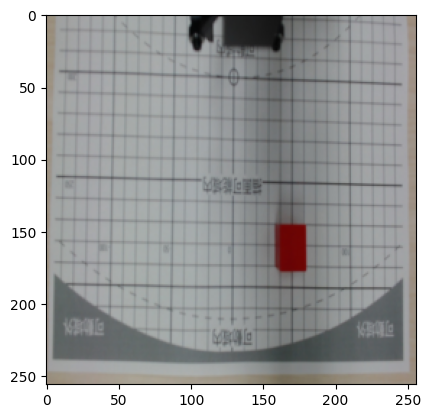

In [ ]:
transformed_img = composed(PIL.Image.fromarray(img_array))
plot_img_from_normalized_img(transformed_img.detach().numpy())

# 検知モデルの定義

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import os

class CubeDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.image_paths = []
        for filename in os.listdir(self.root_dir):
            if filename.endswith(".jpg"):
                self.image_paths.append(os.path.join(self.root_dir, filename))

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img)

        # ボトルの色に基づいてラベルを設定
        label = self.get_label_from_path(img_path)

        return img_tensor, label

    def get_label_from_path(self, path):
        color_mapping = {
            "red": 0,
            "blue": 1,
        }
        for color in color_mapping:
            if color in path:
                return color_mapping[color]

        return -1  # エラーラベル
class CubeClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CubeClassifier, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# データセットを作成
red_dataset = CubeDataset("/content/AI_data/train/redblock")
blue_dataset = CubeDataset("/content/AI_data/train/blueblock")


# データセットの分割
train_size = int(0.8 * len(red_dataset))
val_size = len(red_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(red_dataset, [train_size, val_size])

train_size_blue = int(0.8 * len(blue_dataset))
val_size_blue = len(blue_dataset) - train_size_blue
train_dataset_blue, val_dataset_blue = torch.utils.data.random_split(blue_dataset, [train_size_blue, val_size_blue])

train_loader = DataLoader(train_dataset + train_dataset_blue, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset + val_dataset_blue, batch_size=8, shuffle=False)

# モデルを定義
model = CubeClassifier(num_classes=2)

# 損失関数とオプティマイザを定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


## モデルのトレーニング

In [ ]:
# 学習を実行
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, loss: {running_loss/(i+1)}")

    # バリデーション
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Validation loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")

# 学習済みモデルを保存
torch.save(model.state_dict(), "cube_classifier.pth")

Epoch 1, loss: 0.5256145671010017
Validation loss: 0.6581190526485443, Accuracy: 62.5%
Epoch 2, loss: 0.1936343563720584
Validation loss: 0.4183070659637451, Accuracy: 100.0%
Epoch 3, loss: 0.07919596112333238
Validation loss: 0.11376922391355038, Accuracy: 100.0%
Epoch 4, loss: 0.05338511383160949
Validation loss: 0.0074797135312110186, Accuracy: 100.0%
Epoch 5, loss: 0.008544565498596057
Validation loss: 0.002390993060544133, Accuracy: 100.0%
Epoch 6, loss: 0.018949118064483628
Validation loss: 0.001503369363490492, Accuracy: 100.0%
Epoch 7, loss: 0.040763304074062034
Validation loss: 0.003483130072709173, Accuracy: 100.0%
Epoch 8, loss: 0.011681803051033057
Validation loss: 0.0063543186988681555, Accuracy: 100.0%
Epoch 9, loss: 0.06949548347620293
Validation loss: 0.0016681377310305834, Accuracy: 100.0%
Epoch 10, loss: 0.010516617694520392
Validation loss: 0.13601918357016984, Accuracy: 100.0%


In [ ]:
# 学習を実行
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, loss: {running_loss/(i+1)}")

    # バリデーション
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Validation loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")

# 学習済みモデルを保存
torch.save(model.state_dict(), "cube_classifier_v2.pth")

Epoch 1, loss: 0.03008791187312454
Validation loss: 0.004611634594766656, Accuracy: 100.0%
Epoch 2, loss: 0.009416543318366166
Validation loss: 0.000927766173845157, Accuracy: 100.0%
Epoch 3, loss: 0.0037418140054796822
Validation loss: 0.0004773330729221925, Accuracy: 100.0%
Epoch 4, loss: 0.2144246734897024
Validation loss: 0.01327978793415241, Accuracy: 100.0%
Epoch 5, loss: 0.006962191866477951
Validation loss: 0.010820668190717697, Accuracy: 100.0%
Epoch 6, loss: 0.008813502470729873
Validation loss: 0.004689847119152546, Accuracy: 100.0%
Epoch 7, loss: 0.01912012846150901
Validation loss: 0.002847894880687818, Accuracy: 100.0%
Epoch 8, loss: 0.0031019827438285574
Validation loss: 0.0016469585534650832, Accuracy: 100.0%
Epoch 9, loss: 0.004113537885132246
Validation loss: 0.0005352610896807164, Accuracy: 100.0%
Epoch 10, loss: 0.0036012157652294263
Validation loss: 0.00024005298473639414, Accuracy: 100.0%


## モデルの精度を検証

In [ ]:
# テストコード
import torch.nn.functional as F

# モデルのパラメータを保存したチェックポイントファイルへのパス
checkpoint_path = 'cube_classifier_v2.pth'
# テスト画像へのパス
test_image_path = '/content/AI_data/test/block (15).jpg'
# 各クラスの名前
classes = ['red', 'blue']

# 画像を読み込む
image = Image.open(test_image_path)

# 前処理を行う
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image = preprocess(image)
image = image.unsqueeze(0)  # バッチサイズの次元を追加する

# モデルを定義する
test_model = CubeClassifier(num_classes=2)
# 重みを読み込む
test_model.load_state_dict(torch.load(checkpoint_path))

# 推論を行う
test_model.eval()
with torch.no_grad():
    # モデルに入力し、予測を取得する
    output = test_model(image)
    probabilities = F.softmax(output, dim=1)
    probabilities_np = probabilities.numpy()
    probabilities_np_rounded = np.round(probabilities_np*100, 3)
    blue_prob = probabilities_np_rounded[0][1]
    red_prob = probabilities_np_rounded[0][0]
    print(f"青の確率: {blue_prob}%, 赤の確率: {red_prob}%")

    predicted_class = torch.argmax(probabilities, dim=1).item()

# 結果を表示する
print(f"予測結果: {classes[predicted_class]}")

青の確率: 42.9119987487793%, 赤の確率: 57.0880012512207%
予測結果: red


In [ ]:
# テストコード
import torch.nn.functional as F

# モデルのパラメータを保存したチェックポイントファイルへのパス
checkpoint_path = 'cube_classifier.pth'
# テスト画像へのパス
test_image_path = '/content/AI_data/test/block (10).jpg'
# 各クラスの名前
classes = ['red', 'blue']

# 画像を読み込む
image = Image.open(test_image_path)

# 前処理を行う
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image = preprocess(image)
image = image.unsqueeze(0)  # バッチサイズの次元を追加する

# モデルを定義する
test_model = CubeClassifier(num_classes=2)
# 重みを読み込む
test_model.load_state_dict(torch.load(checkpoint_path))

# 推論を行う
test_model.eval()
with torch.no_grad():
    # モデルに入力し、予測を取得する
    output = test_model(image)
    probabilities = F.softmax(output, dim=1)
    probabilities_np = probabilities.numpy()
    probabilities_np_rounded = np.round(probabilities_np*100, 3)
    blue_prob = probabilities_np_rounded[0][1]
    red_prob = probabilities_np_rounded[0][0]
    print(f"青の確率: {blue_prob}%, 赤の確率: {red_prob}%")

    predicted_class = torch.argmax(probabilities, dim=1).item()

# 結果を表示する
print(f"予測結果: {classes[predicted_class]}")

青の確率: 1.4739999771118164%, 赤の確率: 98.5260009765625%
予測結果: red


In [ ]:
# テストコード
import torch.nn.functional as F

# モデルのパラメータを保存したチェックポイントファイルへのパス
checkpoint_path = 'cube_classifier.pth'
# テスト画像へのパス
test_image_path = '/content/AI_data/test/block (20).jpg'
# 各クラスの名前
classes = ['red', 'blue']

# 画像を読み込む
image = Image.open(test_image_path)

# 前処理を行う
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image = preprocess(image)
image = image.unsqueeze(0)  # バッチサイズの次元を追加する

# モデルを定義する
test_model = CubeClassifier(num_classes=2)
# 重みを読み込む
test_model.load_state_dict(torch.load(checkpoint_path))

# 推論を行う
test_model.eval()
with torch.no_grad():
    # モデルに入力し、予測を取得する
    output = test_model(image)
    probabilities = F.softmax(output, dim=1)
    probabilities_np = probabilities.numpy()
    probabilities_np_rounded = np.round(probabilities_np*100, 3)
    blue_prob = probabilities_np_rounded[0][1]
    red_prob = probabilities_np_rounded[0][0]
    print(f"青の確率: {blue_prob}%, 赤の確率: {red_prob}%")

    predicted_class = torch.argmax(probabilities, dim=1).item()

# 結果を表示する
print(f"予測結果: {classes[predicted_class]}")

青の確率: 0.41600000858306885%, 赤の確率: 99.58399963378906%
予測結果: red


In [ ]:
# テストコード
import torch.nn.functional as F

# モデルのパラメータを保存したチェックポイントファイルへのパス
checkpoint_path = 'cube_classifier.pth'
# テスト画像へのパス
test_image_path = '/content/AI_data/test/block (15).jpg'
# 各クラスの名前
classes = ['red', 'blue']

# 画像を読み込む
image = Image.open(test_image_path)

# 前処理を行う
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image = preprocess(image)
image = image.unsqueeze(0)  # バッチサイズの次元を追加する

# モデルを定義する
test_model = CubeClassifier(num_classes=2)
# 重みを読み込む
test_model.load_state_dict(torch.load(checkpoint_path))

# 推論を行う
test_model.eval()
with torch.no_grad():
    # モデルに入力し、予測を取得する
    output = test_model(image)
    probabilities = F.softmax(output, dim=1)
    probabilities_np = probabilities.numpy()
    probabilities_np_rounded = np.round(probabilities_np*100, 3)
    blue_prob = probabilities_np_rounded[0][1]
    red_prob = probabilities_np_rounded[0][0]
    print(f"青の確率: {blue_prob}%, 赤の確率: {red_prob}%")

    predicted_class = torch.argmax(probabilities, dim=1).item()

# 結果を表示する
print(f"予測結果: {classes[predicted_class]}")

青の確率: 1.7979999780654907%, 赤の確率: 98.2020034790039%
予測結果: red


In [ ]:
# テストコード
import torch.nn.functional as F

# モデルのパラメータを保存したチェックポイントファイルへのパス
checkpoint_path = 'cube_classifier.pth'
# テスト画像へのパス
test_image_path = '/content/AI_data/test/block (13).jpg'
# 各クラスの名前
classes = ['red', 'blue']

# 画像を読み込む
image = Image.open(test_image_path)

# 前処理を行う
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image = preprocess(image)
image = image.unsqueeze(0)  # バッチサイズの次元を追加する

# モデルを定義する
test_model = CubeClassifier(num_classes=2)
# 重みを読み込む
test_model.load_state_dict(torch.load(checkpoint_path))

# 推論を行う
test_model.eval()
with torch.no_grad():
    # モデルに入力し、予測を取得する
    output = test_model(image)
    probabilities = F.softmax(output, dim=1)
    probabilities_np = probabilities.numpy()
    probabilities_np_rounded = np.round(probabilities_np*100, 3)
    blue_prob = probabilities_np_rounded[0][1]
    red_prob = probabilities_np_rounded[0][0]
    print(f"青の確率: {blue_prob}%, 赤の確率: {red_prob}%")

    predicted_class = torch.argmax(probabilities, dim=1).item()

# 結果を表示する
print(f"予測結果: {classes[predicted_class]}")

青の確率: 1.319000005722046%, 赤の確率: 98.68099975585938%
予測結果: red
